# Training Deep Neural Networks on a GPU with PyTorch

Unlike the linear or logistic model we used in previous notebooks, we will use a feed-forward neural network here to capture non-linear relationships between inputs and targets. See the [Universal Approximation Theorem](http://neuralnetworksanddeeplearning.com/chap4.html) for more info. For the calculation of gradients in neural networks with multiple layers and the subsequent weight update, see [Stanford CS229 Lecture notes on Backpropagation](https://github.com/BirajCoder/File-host-repo/blob/main/backprop.pdf).

## Example: MNIST digit classification with feed-forward neural network

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
# Prepare data

# Download dataset
dataset = MNIST(root='data/', download=True, transform=ToTensor())

# Split dataset into training and validation datasets

val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

# Create data loaders
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
# Note: see documentation for the use of num_workers and pin_memory arguments


In [ ]:
# To inspect the images:
# for images, _ in train_loader:
#     print('images.shape:', images.shape)
#     plt.figure(figsize=(16,8))
#     plt.axis('off')
#     plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0))) # make_grid: PyTorch function for arranging images in a grid; # plt.imshow expects channels to be last dimension, so use permute to rearrange dimensions
#     break

## Hidden Layers

The following model has two layers of neural network:
- one hidden layer (a linear model)
- one output layer (a linear model)

Between the two layers, we will add an activation function to capture non-linear relationships between inputs and outputs.




## Activation function and non-linearity

ReLU will be used as the activation function for the outputs:

`relu(x) = max(0,x)`

ReLU is a non-linear function that converts negative values to 0.

<img src="https://i.imgur.com/yijV4xF.png" width="420">

The resulting neural network looks like this:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">

In [ ]:
# Example of a neural network with two layers

# Get a batch of input tensors for demonstration
for images, labels in train_loader:
    inputs = images.reshape(-1, 784) # flatten 28*28 image tensors to 1*784 tensors
    break

# Create first NN layer (layer1)
input_size = inputs.shape[-1] # same as batch size (i.e. 128)
hidden_size = 32 # learning capacity
layer1 = nn.Linear(input_size, hidden_size)
layer1_outputs = layer1(inputs) # the size of layer1_outputs should be 128*32

# Activation function
relu_outputs = F.relu(layer1_outputs)

# Create 2nd NN layer (layer2). This is the final output layer
output_size = 10 # The final output has 10 scores for 10 labels
layer2 = nn.Linear(hidden_size, output_size)
layer2_outputs = layer2(relu_outputs)

# # The above neural network can be written in one line
# outputs_expanded = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias
# torch.allclose(outputs_expanded, layer2_outputs, 1e-3) # use allclose to verify if two tensors are equal (tolerated range of error: 1e-3)

## Model

Like building a logistic model in the previous notebook, we will extend the nn.Module to build the model with a feedforward neural network.

In [ ]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

# evaluation metric
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# Create the model
input_size = 784
hidden_size = 32
num_classes = 10
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

The model has one set of weights and one set of bias for each layers. (For two layers, we have 4 tensors.)

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


## Using a GPU

For Google Colab or Kaggle users:
- Google Colab: Runtime > Change Runtime Type > select "GPU"
- Kaggle: In "Settings" select "GPU"

In [ ]:
# Check if GPU is available
torch.cuda.is_available()

True

In [ ]:
# Function to select GPU if it's available
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Function to move data and model to a chosen device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data] # for a list of tensors/models
    return data.to(device, non_blocking=True)  # for one tensor/model

# Example use
device = get_default_device()
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [ ]:
# To move data to the selected device, we can simply wrap the existing data loaders with the following function.
# (This function return a data loader with the same batches of data after moving the data to the selected device.)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device. Return a dataloader (generator)."""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device) # yield: see note below

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# Examples
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

# Note: You can create a generator function using yield.
# def my_generator():
#     # Create a generator function with 3 items
#     yield 10
#     yield 20
#     yield 30
# # the above generator function can be used in a for loop:
# for item in my_generator():
#     print(item)

## Training the Model


In [ ]:
 # Define functions for training

def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr) # parameters include weights and biases from all layers
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# Move model to the same device as the data
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

# Training
history = fit(10, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2331, val_acc: 0.9337
Epoch [1], val_loss: 0.1782, val_acc: 0.9500
Epoch [2], val_loss: 0.1563, val_acc: 0.9563
Epoch [3], val_loss: 0.1640, val_acc: 0.9530
Epoch [4], val_loss: 0.1449, val_acc: 0.9590
Epoch [5], val_loss: 0.1375, val_acc: 0.9602
Epoch [6], val_loss: 0.1323, val_acc: 0.9635
Epoch [7], val_loss: 0.1323, val_acc: 0.9634
Epoch [8], val_loss: 0.1504, val_acc: 0.9592
Epoch [9], val_loss: 0.1295, val_acc: 0.9645


## Testing with individual images in the test dataset

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=ToTensor())

# Helper function
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


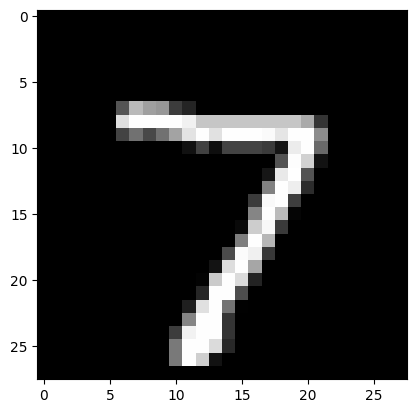

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

# Check the accuracy/loss on the test set
The numbers for the test set should be similar to those for the validation set. If not, we might need another validation set which has similar data distribution as the test set.

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10948429256677628, 'val_acc': 0.96728515625}

## Save the model parameters

In [ ]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')